**📄 Taxi Fare Prediction – LightGBM Training Script Summary**

This script loads 31,694 Chicago taxi trip records, performs feature engineering, trains a LightGBM regression model, evaluates performance, shows visualizations, and saves the model for later prediction.

✅ Data successfully loaded into a Pandas DataFrame!
✅ Selected features and target extracted. Initial Data Shape: (31694, 6)
<bound method NDFrame.head of         TRIP_START_TIMESTAMP      TRIP_END_TIMESTAMP  TRIP_MILES  \
0      05/17/2022 7:15:00 AM   05/17/2022 7:45:00 AM        2.57   
1      05/17/2022 5:15:00 PM   05/17/2022 5:30:00 PM        1.18   
2      05/17/2022 5:15:00 PM   05/17/2022 5:30:00 PM        1.29   
3      05/17/2022 6:00:00 PM   05/17/2022 7:00:00 PM        3.70   
4      05/17/2022 5:00:00 PM   05/17/2022 5:30:00 PM        1.15   
...                      ...                     ...         ...   
31689  05/17/2022 1:15:00 PM   05/17/2022 1:30:00 PM       13.06   
31690  05/17/2022 9:45:00 PM  05/17/2022 10:15:00 PM       30.90   
31691  05/18/2022 3:45:00 AM   05/18/2022 4:00:00 AM       12.21   
31692  05/16/2022 2:45:00 PM   05/16/2022 3:30:00 PM       36.60   
31693  05/16/2022 9:30:00 PM  05/16/2022 10:00:00 PM       36.70   

       TRIP_SECONDS  TRIP_ST

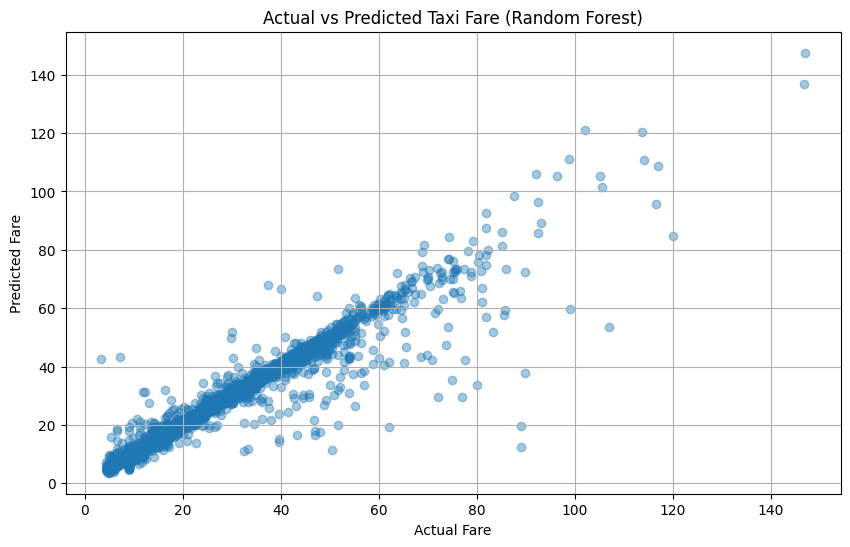

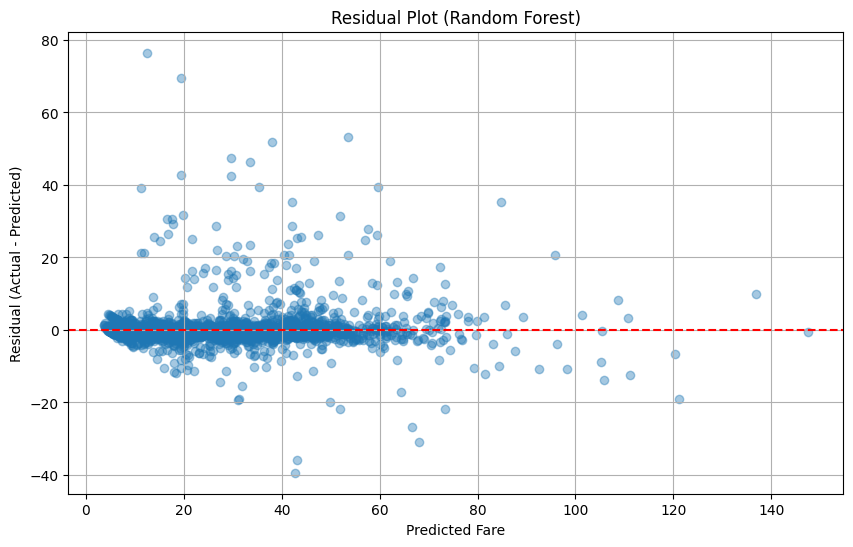

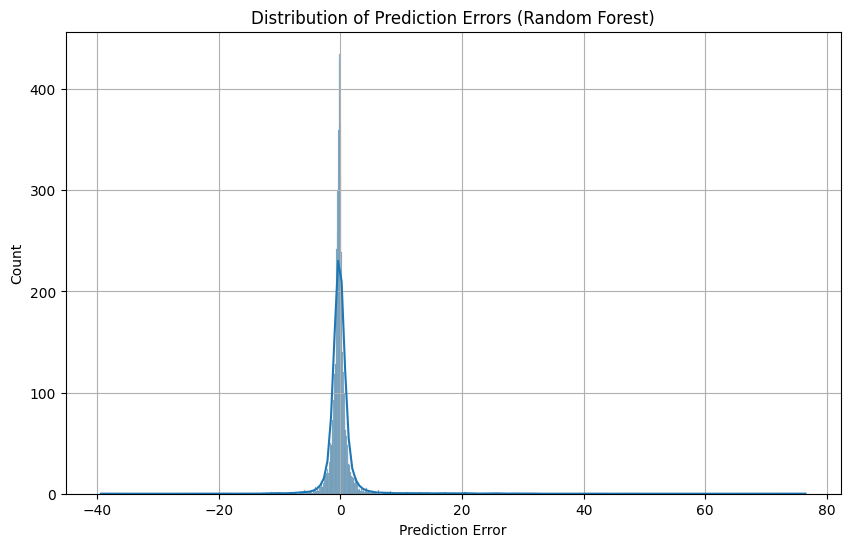

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # The intended model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from lightgbm import LGBMRegressor

# --- Configuration ---
chicago_taxi_faircsv = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRlaCuzmR82rXAw1bW6yVxH7MiLB7S2yfDor5FgfjqGxPv-1OBr3pMjVDojDF_54eemicI9hlfgcoQM/pub?gid=1980352949&single=true&output=csv'

selected_features = [
    'TRIP_START_TIMESTAMP',
    'TRIP_END_TIMESTAMP',
    'TRIP_MILES',
    'TRIP_SECONDS',
    'TRIP_START_HOUR',
    'FARE'
]

# --- Data Processing and Model Training ---
try:
    # 1. Load and Select Data (No change)
    df_full = pd.read_csv(chicago_taxi_faircsv)
    print("✅ Data successfully loaded into a Pandas DataFrame!")
    df = df_full[selected_features].copy()
    print(f"✅ Selected features and target extracted. Initial Data Shape: {df.shape}")
    print(df.head)
    # 2. Feature Engineering (No change)
    print("\n⏰ Applying Feature Engineering (Duration, Rush Hour, Speed)...")
    df['START_TIME'] = pd.to_datetime(df['TRIP_START_TIMESTAMP'])
    df['END_TIME'] = pd.to_datetime(df['TRIP_END_TIMESTAMP'])
    df['TRIP_DURATION'] = (df['END_TIME'] - df['START_TIME']).dt.total_seconds()

    # Create RUSH_HOUR Feature
    df['RUSH_HOUR'] = np.where(
        (df['TRIP_START_HOUR'].between(7, 9, inclusive='both')) |
        (df['TRIP_START_HOUR'].between(16, 18, inclusive='both')),
        1,  # Is rush hour
        0   # Is not rush hour
    )

    # Create AVERAGE_SPEED Feature
    df['AVERAGE_SPEED_MPH'] = df['TRIP_MILES'] / (df['TRIP_SECONDS'] / 3600 + 1e-6)

    # Drop non-numerical and redundant columns
    df = df.drop(columns=['TRIP_START_TIMESTAMP', 'TRIP_END_TIMESTAMP', 'START_TIME', 'END_TIME'])
    print("✅ Feature engineering complete. New features added.")

    # 3. Create X (Features) and y (Target)
    X = df[[
        'TRIP_MILES',
        'TRIP_SECONDS', # Keep original seconds, or use TRIP_DURATION, but not both in this simplified model
        'TRIP_START_HOUR',
        'RUSH_HOUR',
        'AVERAGE_SPEED_MPH'
    ]]
    y = df['FARE']
    print(f"Features (X) shape: {X.shape}, Target (y) shape: {y.shape}")

    # 4. Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42
    )
    print("✅ Data split into training (80%) and testing (20%) sets.")

    # 5. Train the LightGBM model (The FIX)
    print("\n🌲 Training LightGBM...")
    model_lgbm = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=50,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
    )

    # --- CRITICAL FIX 1: Use the new model_lgbm variable for fitting ---
    model_lgbm.fit(X_train, y_train)


    print("✅ Model LightGBM training complete!")

    # 6. Predict and Evaluate (The FIX)
    # --- CRITICAL FIX 2: Use the new model_lgbm variable for prediction ---
    y_pred = model_lgbm.predict(X_test)
    print("successfully predicted on test data")

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print("\n--- LightGBM Performance Metrics ---")
    # --- CRITICAL FIX 3: Use model_lgbm for scoring ---
    print(f"R-squared on training data: {model_lgbm.score(X_train, y_train):.4f}")
    print(f"MAE (Mean Absolute Error): {mae:.4f}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"R² (R-squared on test data): {r2:.4f}")

    # 7. Print Feature Importances LightGBM ( Specific Output)
    feature_names = X.columns

    print("\n--- Feature Importance (LightGBM) ---")
    # --- CRITICAL FIX 4: LightGBM has feature_importances_ not coef_ ---
    importances = model_lgbm.feature_importances_
    for name, importance in zip(feature_names, importances):
        print(f"{name:<20}: {importance:.4f}")
    joblib.dump(model_lgbm, "taxi_model.joblib")


    print("✅ Model successfully saved to the file 'taxi_model.joblib'")
    # 8. Visualization (Use y_pred for plots)
    # The plotting code uses y_pred, which is correctly calculated using model_rf
    # ... (Plotting code remains the same) ...
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.4)
    plt.xlabel("Actual Fare")
    plt.ylabel("Predicted Fare")
    plt.title("Actual vs Predicted Taxi Fare (Random Forest)")
    plt.grid(True)
    plt.show()

    residuals = y_test - y_pred

    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.4)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Predicted Fare")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.title("Residual Plot (Random Forest)")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.xlabel("Prediction Error")
    plt.title("Distribution of Prediction Errors (Random Forest)")
    plt.grid(True)
    plt.show()


except Exception as e:
    print(f"❌ An error occurred during processing or training. Error: {e}")



**---📄 Taxi Fare Prediction – Test Script Summary**

This Python script loads the trained LightGBM Taxi Fare Prediction model and allows the user to enter trip details (distance, time, and hour of day).
It then performs feature engineering exactly the same way the model was trained, and finally predicts the taxi fare.



In [7]:
import joblib
import numpy as np
import pandas as pd

model = joblib.load("taxi_model.joblib")
print("✅ Model loaded successfully.")

def predict_fare(TRIP_MILES, TRIP_SECONDS, TRIP_START_HOUR):

    # ---- Feature Engineering ----
    RUSH_HOUR = 1 if ((7 <= TRIP_START_HOUR <= 9) or (16 <= TRIP_START_HOUR <= 18)) else 0
    AVERAGE_SPEED_MPH = TRIP_MILES / (TRIP_SECONDS / 3600 + 1e-6)



    # Create DataFrame with correct feature names
    X = pd.DataFrame([{
        'TRIP_MILES': TRIP_MILES,
        'TRIP_SECONDS': TRIP_SECONDS,
        'TRIP_START_HOUR': TRIP_START_HOUR,
        'RUSH_HOUR': RUSH_HOUR,
        'AVERAGE_SPEED_MPH': AVERAGE_SPEED_MPH,
    }])

    fare = model.predict(X)[0]
    return fare


# ---- User Input ----
miles = float(input("Miles: "))
seconds = int(input("Seconds: "))
hour = float(input("Start Hour (0-23): "))

prediction = predict_fare(miles, seconds, hour)
print("Predicted Fare:", round(prediction, 2))


✅ Model loaded successfully.
Miles: 3.4
Seconds: 450
Start Hour (0-23): 8
Predicted Fare: 9.84
